Варіаційний автокодувальник

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras.losses import binary_crossentropy

Epoch 1/10
469/469 [==============================] - 8s 14ms/step - loss: 0.3089 - val_loss: 0.2647
Epoch 2/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2640 - val_loss: 0.2633
Epoch 3/10
469/469 [==============================] - 6s 14ms/step - loss: 0.2633 - val_loss: 0.2631
Epoch 4/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2631 - val_loss: 0.2630
Epoch 5/10
469/469 [==============================] - 6s 14ms/step - loss: 0.2631 - val_loss: 0.2629
Epoch 6/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2631 - val_loss: 0.2628
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 8/10
469/469 [==============================] - 7s 14ms/step - loss: 0.2630 - val_loss: 0.2629
Epoch 9/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2630 - val_loss: 0.2629
Epoch 10/10
469/469 [==============================] - 6s 14ms/step - loss: 0.2630 - val_lo

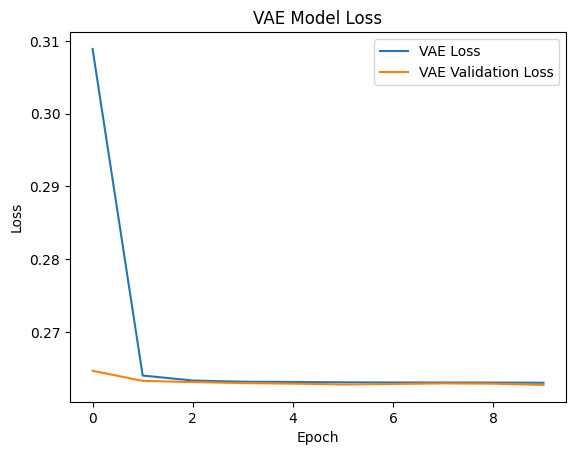

313/313 [==============================] - 1s 3ms/step


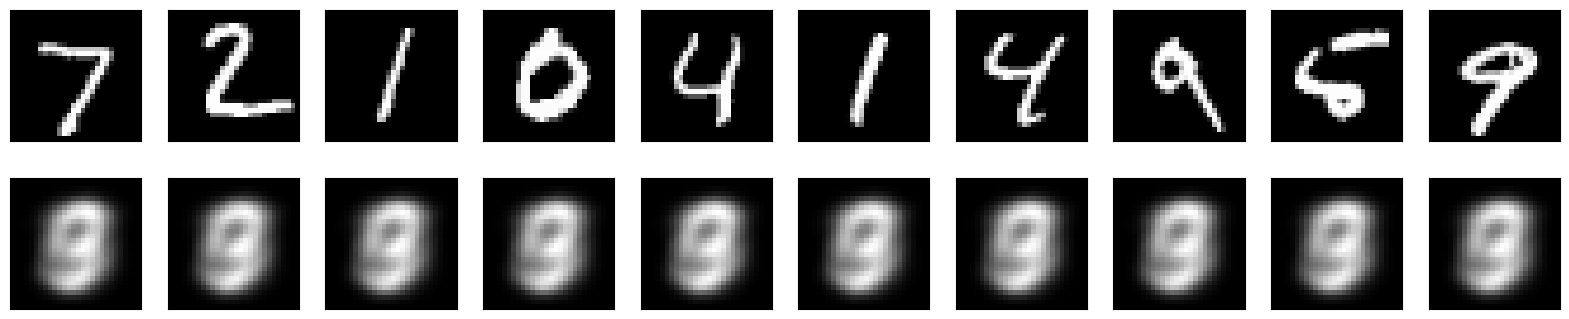

In [10]:
# MNIST
(x_train, _), (x_test, _) = mnist.load_data()

x_train_flat = x_train.reshape(len(x_train), 784) / 255.
x_test_flat = x_test.reshape(len(x_test), 784) / 255.

original_dim = 784
latent_dim = 2
intermediate_dim = 256
batch_size = 128
epochs = 10

# Енкодер
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Застосування функції семплювання для отримання z
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Декодер
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Модель автокодувальника
vae = Model(x, x_decoded_mean)

# Функція втрат
xent_loss = binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Навчання автокодувальника
history_vae = vae.fit(x_train_flat,
                      shuffle=True,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test_flat, None))

# Графік функції втрат
plt.plot(history_vae.history['loss'], label='VAE Loss')
plt.plot(history_vae.history['val_loss'], label='VAE Validation Loss')
plt.title('VAE Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

decoded_imgs = vae.predict(x_test_flat)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригінальні зображення
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_flat[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Відновлені зображення
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()